In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
import random

# **1. Weather Classication**

# *1. Data preprocessing*

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

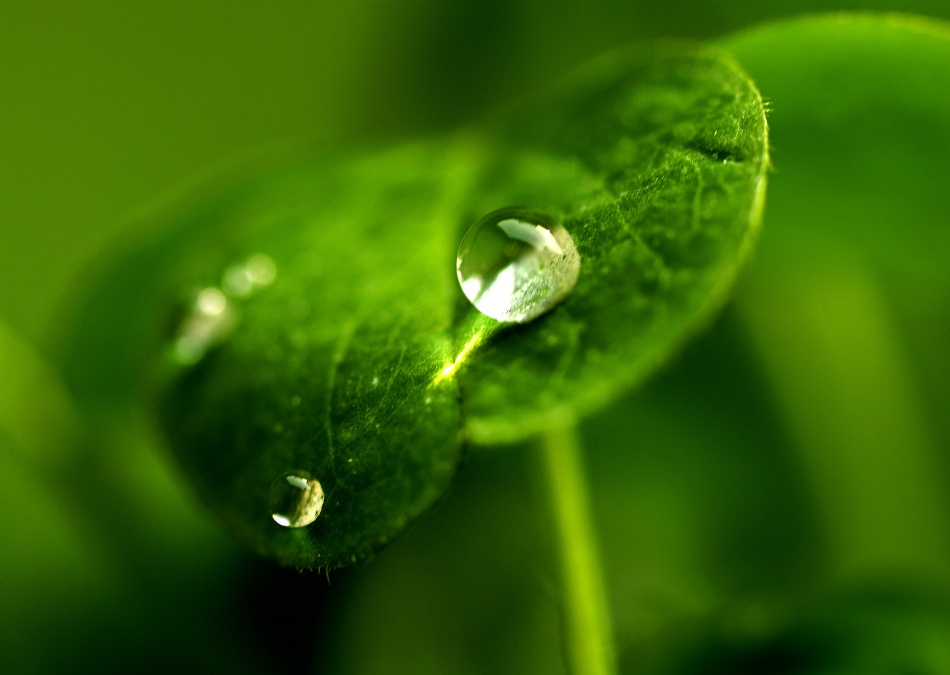

In [3]:
img = Image.open('/kaggle/input/aio-datasets/Data/img_cls_weather_dataset/weather-dataset/dataset/dew/2208.jpg')
img = img.convert('RGB')
img

In [4]:
data_path = '/kaggle/input/aio-datasets/Data/img_cls_weather_dataset/weather-dataset/dataset'
_, folders,_ = next(os.walk(data_path))
folders

['hail',
 'rainbow',
 'frost',
 'rime',
 'fogsmog',
 'snow',
 'rain',
 'glaze',
 'lightning',
 'sandstorm',
 'dew']

In [5]:
count_dict = {}
labels = []
data_paths = []
for (i, label) in enumerate(folders):
    file_path = os.path.join(data_path, label)
    _, _, files_list = next(os.walk(file_path))
    count_dict[label] = len(files_list)
    for file in files_list:
        path = os.path.join(file_path, file)
        data_paths.append(path)
        labels.append(i)

print('data_len: ', len(data_paths), len(labels))
print(count_dict)

data_len:  6862 6862
{'hail': 591, 'rainbow': 232, 'frost': 475, 'rime': 1160, 'fogsmog': 851, 'snow': 621, 'rain': 526, 'glaze': 639, 'lightning': 377, 'sandstorm': 692, 'dew': 698}


<BarContainer object of 11 artists>

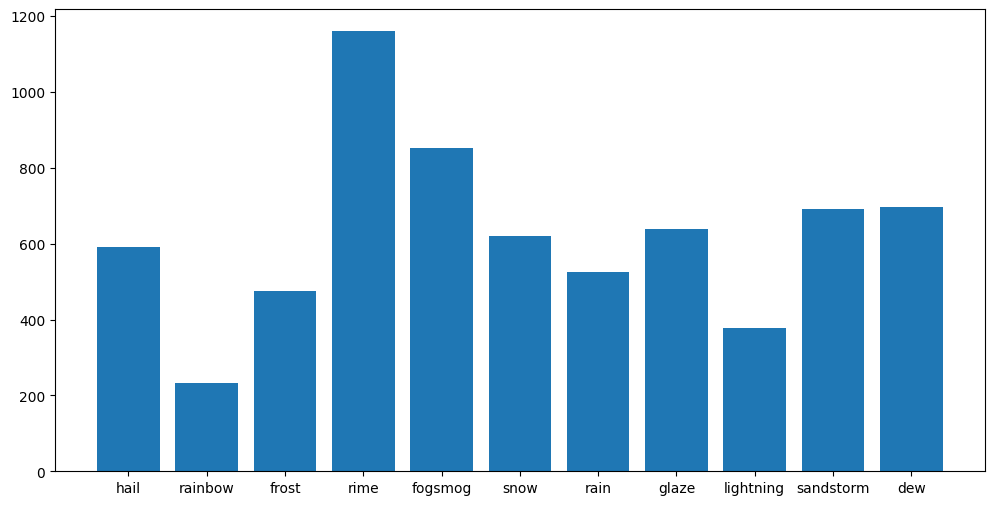

In [6]:
plt.figure(figsize=(12, 6))
plt.bar(count_dict.keys(), count_dict.values())

In [7]:
train_data, valid_data, train_label, valid_label = train_test_split(data_paths, labels, test_size=0.2, shuffle=True)
valid_data, test_data, valid_label, test_label = train_test_split(valid_data, valid_label, test_size=0.5, shuffle=True)
print('train, valid, test: ', len(train_data), len(valid_data), len(test_data))

train, valid, test:  5489 686 687


In [8]:
class WeatherDataset(Dataset):
    def __init__(self, img_paths, label_paths, transform=None):
        self.img_paths = img_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
        
    def __getitem__(self, id):
        img = Image.open(self.img_paths[id]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.label_paths[id]


In [9]:
def transform(img, size=(224, 224, 3)):
    img = np.array(img)
    img = np.resize(img, size)
    img = np.transpose(img, (2, 0, 1))
    img = torch.tensor(img).float()
    img = img / 255.0
    return img

In [10]:
train_dataset = WeatherDataset(train_data, train_label, transform=transform)
valid_dataset = WeatherDataset(valid_data, valid_label, transform=transform)
test_dataset = WeatherDataset(test_data, test_label, transform=transform)

In [11]:
train_batch_size = 512
valid_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=valid_batch_size, shuffle=False)


# *2. Define Model*

In [12]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

***ResNet***
* The number of channels in the ***first module*** is the same 
as the number of input channel
* In the ***first residual block*** for 
each of the subsequent modules, the number of channels is***doubled***d compared with that o 
the previous module, and the height and width are halved.
s

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv2d_1 = nn.Conv2d(in_channel, out_channel, 
                                  kernel_size=3, padding=1, stride=stride)
        
        self.bn1 = nn.BatchNorm2d(num_features=out_channel)
        
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, 
                                      kernel_size=3, padding=1, stride=1)
        
        self.bn2 = nn.BatchNorm2d(num_features=out_channel)
        
        if (stride != 1) or (in_channel != out_channel):
            self.downsampling = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channel)
            )
            
        else:
            self.downsampling = None
            
            
    def forward(self, x):
        res_net = x.clone()
        x = F.relu(self.bn1(self.conv2d_1(x)))
        x = self.bn2(self.conv2d_2(x))
        if self.downsampling:
            res_net = self.downsampling(res_net)
            x += res_net
        else:
            x += res_net
        return F.relu(x)

class FirstBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(out_channel)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.maxpool(self.bn(F.relu(self.conv(x))))

class ResNet(nn.Module):
    
    def __init__(self, first_block, residual_block, in_channel ,out_classes):
        super().__init__()
        self.conv1 = first_block(in_channel=3, out_channel=64)
        self.conv2 = self.create_module(residual_block=ResidualBlock, in_channel=64, out_channel=64, 
                                          num_residual_block=2, stride=1)
        self.conv3 = self.create_module(residual_block=ResidualBlock, in_channel=64, out_channel=128, 
                                          num_residual_block=2, stride=2)
        self.conv4 = self.create_module(residual_block=ResidualBlock, in_channel=128, out_channel=256, 
                                          num_residual_block=2, stride=2)
        self.conv5 = self.create_module(residual_block=ResidualBlock, in_channel=256, out_channel=512, 
                                          num_residual_block=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, out_classes)
                                
    def create_module(self, residual_block, 
                      in_channel, out_channel, 
                      num_residual_block, stride=1):
        module = []
        for i in range(num_residual_block):
            if i == 0:
                module.append(residual_block(in_channel, out_channel, stride=stride))
            else:
                module.append(residual_block(out_channel, out_channel, stride=1))

        return nn.Sequential(*module)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [14]:
!pip install torchsummary
from torchsummary import summary

In [15]:
resnet18 = ResNet(first_block=FirstBlock, residual_block=ResidualBlock, in_channel=3 ,out_classes=1000).to(device)
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
        FirstBlock-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,928
       BatchNorm2d-8           [-1, 64, 56, 56]             128
     ResidualBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
    ResidualBlock-14           [-1, 64,

# ***3. Training***

In [16]:
def compute_accucary(predicted, labels):
    predicted = np.array(predicted)
    labels = np.array(labels)
    return np.sum(predicted == labels) * 100 / predicted.shape[0]

In [17]:
def train_one_epoch(train_loader, valid_loader, 
                    model, device, 
                    loss_func, optimizer):
    model.train()
    train_batch_loss = 0.0
    train_labels = []
    train_preds = []
    
    for i, (train_imgs, batch_train_labels) in enumerate(train_loader):
        train_imgs = train_imgs.to(device)
        batch_train_labels = batch_train_labels.to(device)
        optimizer.zero_grad()
        outputs = model(train_imgs)
        train_loss = loss_func(outputs, batch_train_labels)
        train_batch_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        train_preds += (outputs.argmax(dim=1).cpu().tolist())
        train_labels += (batch_train_labels.cpu().tolist())
        
    
    avg_batch_loss = train_batch_loss / len(train_loader)
    train_accuracy_score = compute_accucary(train_preds, train_labels)
    
    return avg_batch_loss, train_accuracy_score

In [18]:
# training
import time

def train(train_loader, valid_loader, model, device, num_epochs, loss_func, optimizer):
    max_valid_acc = 0.0
    
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        avg_train_loss,  train_accuracy_score = train_one_epoch(train_loader, valid_loader, 
                                                                model, device, 
                                                                loss_func, optimizer)
    
        # evaluate
        model.eval()
        valid_batch_loss = 0.0
        valid_labels = []
        valid_preds = []
        with torch.no_grad():
            for valid_imgs, batch_valid_labels in valid_loader:
                valid_imgs = valid_imgs.to(device)
                batch_valid_labels = batch_valid_labels.to(device)
                predicted = model(valid_imgs)
                val_loss = loss_func(predicted, batch_valid_labels)
                valid_batch_loss += val_loss.item()
                valid_preds += (predicted.argmax(dim=1).cpu().tolist())
                valid_labels += (batch_valid_labels.cpu().tolist())
    
        avg_valid_loss = valid_batch_loss / len(valid_loader)
        valid_accuracy_score = compute_accucary(valid_preds, valid_labels)
    
        # save log
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        train_accuracies.append(train_accuracy_score)
        valid_accuracies.append(valid_accuracy_score)
        
        #save best model
        if max_valid_acc < valid_accuracy_score:
            max_valid_acc = valid_accuracy_score
            print(f'save best model at epoch {epoch+1}')
            torch.save(model.state_dict(), './best_model.pt')
        # print log
        print(f"Epoch {epoch+1}/{num_epochs} | {time.time() - start_time}s:")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy_score:.2f}% | Valid Loss: {avg_valid_loss:.4f} | Valid Accuracy: {valid_accuracy_score:.2f}%")
        print('-------------------------------------------------------------------------------------------')
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [19]:
# define hyperparameters

num_epochs = 25
lr = 0.01
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

train_losses, valid_losses, train_accuracies, valid_accuracies = train(train_loader, valid_loader, 
                                                                       resnet18, device, num_epochs, 
                                                                       loss_func, optimizer)

save best model at epoch 1
Epoch 1/25 | 75.46071863174438s:
Train Loss: 3.2539 | Train Accuracy: 20.86% | Valid Loss: 255.2082 | Valid Accuracy: 9.91%
-------------------------------------------------------------------------------------------
save best model at epoch 2
Epoch 2/25 | 43.27831721305847s:
Train Loss: 2.0602 | Train Accuracy: 32.81% | Valid Loss: 6.3983 | Valid Accuracy: 16.62%
-------------------------------------------------------------------------------------------
save best model at epoch 3
Epoch 3/25 | 42.15302085876465s:
Train Loss: 1.7960 | Train Accuracy: 44.34% | Valid Loss: 1.8681 | Valid Accuracy: 39.36%
-------------------------------------------------------------------------------------------
save best model at epoch 4
Epoch 4/25 | 41.987903356552124s:
Train Loss: 1.6024 | Train Accuracy: 47.02% | Valid Loss: 1.9382 | Valid Accuracy: 39.94%
-------------------------------------------------------------------------------------------
save best model at epoch 5
Epo

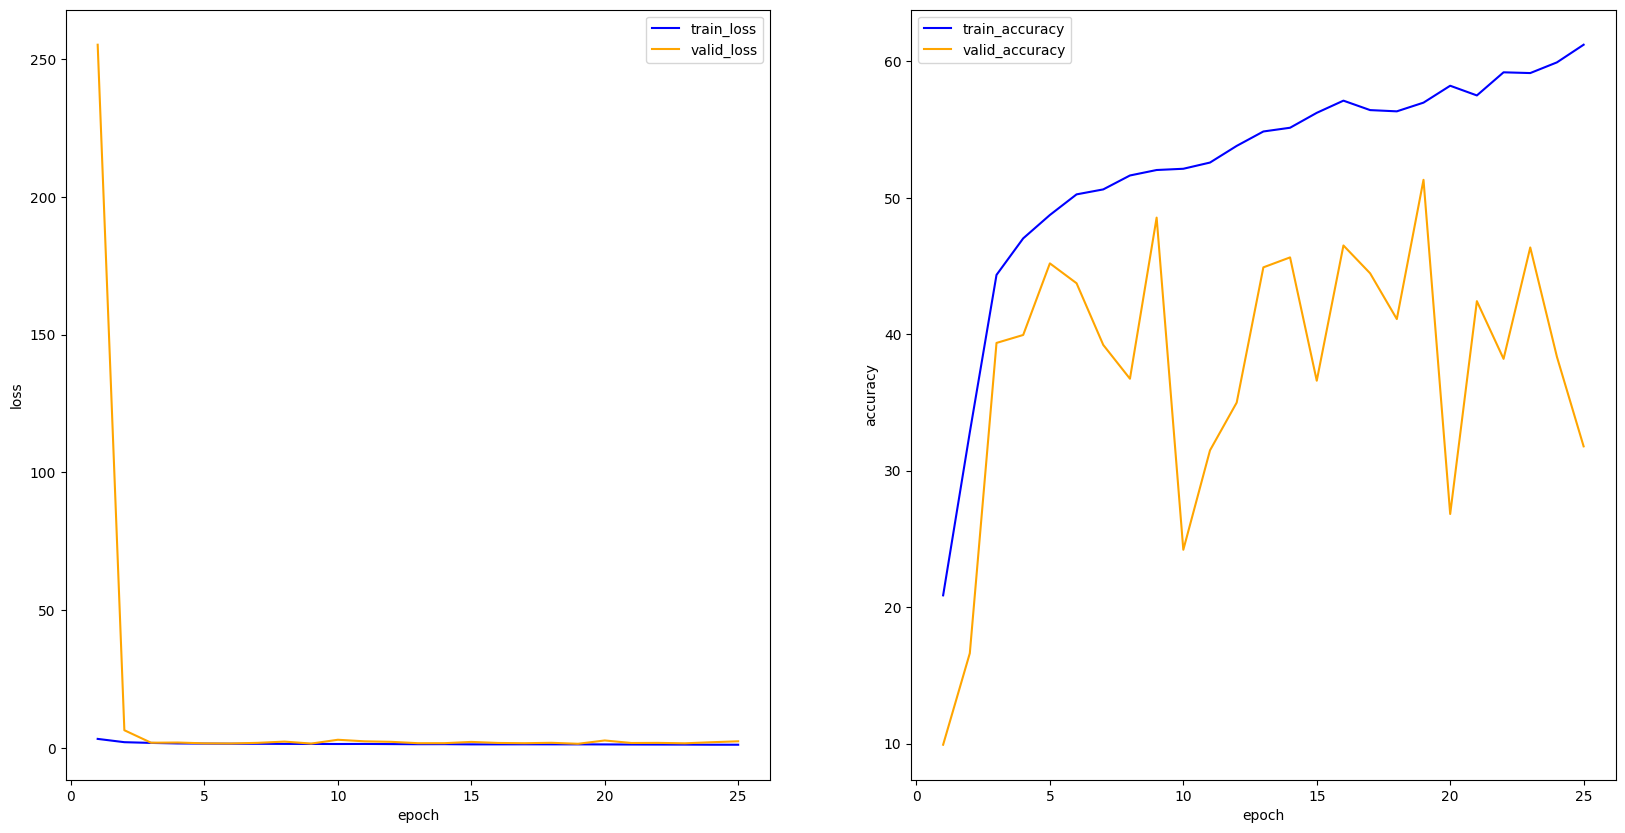

In [20]:
# Plot log
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='train_loss', color='blue')
ax[0].plot(range(1, len(valid_losses) + 1), valid_losses, label='valid_loss', color='orange')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train_accuracy', color='blue')
ax[1].plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='valid_accuracy', color='orange')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

In [21]:
model = ResNet(first_block=FirstBlock, residual_block=ResidualBlock, in_channel=3 ,out_classes=1000).to(device)
model.load_state_dict(torch.load('./best_model.pt', weights_only=True))

<All keys matched successfully>

In [22]:
model.eval()
test_batch_loss = 0.0
test_labels = []
test_preds = []
with torch.no_grad():
    for test_imgs, batch_test_labels in test_loader:
        test_imgs = test_imgs.to(device)
        batch_test_labels = batch_test_labels.to(device)
        predicted = model(test_imgs)
        test_loss = loss_func(predicted, batch_test_labels)
        test_batch_loss += test_loss.item()
        test_preds += (predicted.argmax(dim=1).cpu().tolist())
        test_labels += (batch_test_labels.cpu().tolist())

avg_test_loss = test_batch_loss / len(test_loader)
test_accuracy_score = compute_accucary(test_preds, test_labels)

print(f"Test_loss: {avg_test_loss}")
print(f"Test_acc: {test_accuracy_score}")

Test_loss: 1.3823579626027929
Test_acc: 52.9839883551674
